CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 8 - Assignment
## Basic expectations
- \> = 70% accuracy
- < = 50000
- < = 20 epochs
- C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 (cN is 1x1 Layer)
- 10 misclassified images display

## Version 3 - Group Normalization

### Use Group normalization instead of Batch Normalization
- Used group size of 16

### Results:
- Epochs: 20
- Parameters: 46,000
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=0.9094
  - Accuracy=68.19%
- Testing
  - Average loss: 7891
  - Accuracy: 7300/10000 (73.00%)

### Analysis:
- Group Normalization is better than Layer but not as good as Group for this particular dataset and network
- Number of parameters are lesser than the Layer
- Observation is that the number of Groups need to be optimum - Gave better results for 8 instead of 4 and 16

### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, interpolation=3, fill=0, p=0.1),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with 50000 records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [5]:
train = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [6]:
batch_size = 64

In [7]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

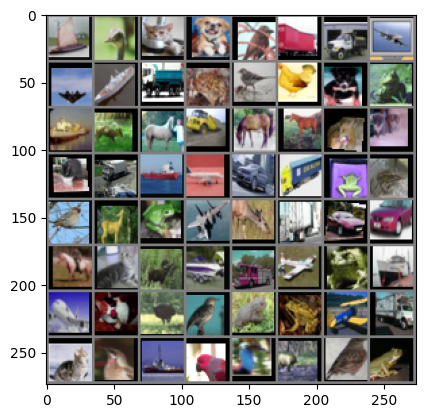

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [8]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [10]:
debug = True
dropout_value = 0.1
num_groups = 8
# Our base model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 32  RF = 3

        # CONVOLUTION BLOCK 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 30 RF = 8

        # TRANSITION BLOCK 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 30


        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # TRANSITION BLOCK 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 11

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.GroupNorm(num_groups, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.GAP = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

        # TRANSITION BLOCK 1
        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        if (debug == True):
          print(f"Start: {x.shape}")

        x = self.C1(x)  # channel size 32 > 32  RF 1 > 3    J 1 > 1
        if (debug == True):
          print(f"C1: {x.shape}")
        x = self.C2(x)  # channel size 32 > 30  RF 3 > 5    J 1 > 1
        if (debug == True):
          print(f"C2: {x.shape}")
        x = self.c3(x)  # channel size 30 > 30  RF 5 > 5    J 1 > 1
        if (debug == True):
          print(f"c3: {x.shape}")
        x = self.C4(x)  # channel size 30 > 28  RF 5 > 7    J 1 > 1
        if (debug == True):
          print(f"C4: {x.shape}")
        x = self.C5(x)  # channel size 28 > 26  RF 7 > 9    J 1 > 1
        if (debug == True):
          print(f"C5: {x.shape}")
        x = self.pool1(x) # channel size 16 > 13  RF 9 > 10    J 1 > 2
        if (debug == True):
          print(f"Pool1: {x.shape}")
        x = self.C6(x)  # channel size 13 > 11  RF 10 > 14    J 2 > 2
        if (debug == True):
          print(f"C6: {x.shape}")
        x = self.c7(x)  # channel size 11 > 11  RF 14 > 14    J 2 > 2
        if (debug == True):
          print(f"c7: {x.shape}")
        x = self.C8(x)  # channel size 11 > 9  RF 14 > 18    J 2 > 2
        if (debug == True):
          print(f"C8: {x.shape}")
        x = self.C9(x)  # channel size 9 > 7  RF 18 > 22    J 2 > 2
        if (debug == True):
          print(f"C9: {x.shape}")
        x = self.C10(x) # channel size 7 > 5  RF 22 > 26    J 2 > 2
        if (debug == True):
          print(f"C10: {x.shape}")

        x = self.GAP(x) # channel size 5 > 1
        if (debug == True):
          print(f"GAP: {x.shape}")

        x = self.c11(x)  # channel size 1 > 1  RF 28 > 28    J 2 > 2
        if (debug == True):
          print(f"c11: {x.shape}")

        x = x.view(-1, 10)
        if (debug == True):
          print(f"Flatten: {x.shape}")

        return F.log_softmax(x, dim=-1)

In [11]:
mymodel = Net().to(device)

summary(mymodel, input_size=(3, 32, 32))

Start: torch.Size([2, 3, 32, 32])
C1: torch.Size([2, 16, 32, 32])
C2: torch.Size([2, 32, 30, 30])
c3: torch.Size([2, 16, 30, 30])
C4: torch.Size([2, 16, 28, 28])
C5: torch.Size([2, 32, 26, 26])
Pool1: torch.Size([2, 32, 13, 13])
C6: torch.Size([2, 32, 11, 11])
c7: torch.Size([2, 16, 11, 11])
C8: torch.Size([2, 32, 9, 9])
C9: torch.Size([2, 32, 7, 7])
C10: torch.Size([2, 32, 5, 5])
GAP: torch.Size([2, 32, 1, 1])
c11: torch.Size([2, 10, 1, 1])
Flatten: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 30, 30]           4,608
         GroupNorm-6           [-1, 32, 30, 30]              64
            

In [12]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc= 100*correct/processed
  print('\nProcessed: {}, Len TrainLoader: {}'.format(processed, len(train_loader)))
  # train_losses.append(train_loss/len(train_loader))
  train_loss = train_loss/len(train_loader)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
      train_loss, correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))

  return train_acc, train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # print("Output:", output)

            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc = (100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_loss

In [13]:
debug = False
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.4021 Batch_id=781 Accuracy=26.82: 100%|██████████| 782/782 [01:03<00:00, 12.37it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.9477, Accuracy: 13410/50000 (26.82%)


Test set: Average loss: 1.6509, Accuracy: 3976/10000 (39.76%)
LR Rate: 0.01 

Epoch 2


Train: Loss=1.5707 Batch_id=781 Accuracy=38.87: 100%|██████████| 782/782 [00:54<00:00, 14.38it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.6628, Accuracy: 19434/50000 (38.87%)


Test set: Average loss: 1.5890, Accuracy: 4243/10000 (42.43%)
LR Rate: 0.01 

Epoch 3


Train: Loss=1.1771 Batch_id=781 Accuracy=45.12: 100%|██████████| 782/782 [00:54<00:00, 14.24it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.5104, Accuracy: 22559/50000 (45.12%)


Test set: Average loss: 1.3533, Accuracy: 5011/10000 (50.11%)
LR Rate: 0.01 

Epoch 4


Train: Loss=1.2372 Batch_id=781 Accuracy=50.17: 100%|██████████| 782/782 [00:54<00:00, 14.25it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.3811, Accuracy: 25087/50000 (50.17%)


Test set: Average loss: 1.2185, Accuracy: 5623/10000 (56.23%)
LR Rate: 0.01 

Epoch 5


Train: Loss=1.1640 Batch_id=781 Accuracy=53.23: 100%|██████████| 782/782 [00:54<00:00, 14.26it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.3012, Accuracy: 26617/50000 (53.23%)


Test set: Average loss: 1.2034, Accuracy: 5702/10000 (57.02%)
LR Rate: 0.01 

Epoch 6


Train: Loss=1.0582 Batch_id=781 Accuracy=55.37: 100%|██████████| 782/782 [00:54<00:00, 14.37it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.2489, Accuracy: 27685/50000 (55.37%)


Test set: Average loss: 1.0795, Accuracy: 6132/10000 (61.32%)
LR Rate: 0.01 

Epoch 7


Train: Loss=1.3900 Batch_id=781 Accuracy=57.41: 100%|██████████| 782/782 [00:54<00:00, 14.28it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1911, Accuracy: 28707/50000 (57.41%)


Test set: Average loss: 1.1378, Accuracy: 5950/10000 (59.50%)
LR Rate: 0.01 

Epoch 8


Train: Loss=0.4969 Batch_id=781 Accuracy=59.42: 100%|██████████| 782/782 [00:54<00:00, 14.46it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1447, Accuracy: 29708/50000 (59.42%)


Test set: Average loss: 1.1466, Accuracy: 6017/10000 (60.17%)
LR Rate: 0.01 

Epoch 9


Train: Loss=0.9287 Batch_id=781 Accuracy=60.64: 100%|██████████| 782/782 [00:54<00:00, 14.42it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1091, Accuracy: 30321/50000 (60.64%)


Test set: Average loss: 0.9826, Accuracy: 6548/10000 (65.48%)
LR Rate: 0.01 

Epoch 10


Train: Loss=0.6848 Batch_id=781 Accuracy=61.89: 100%|██████████| 782/782 [00:54<00:00, 14.28it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0771, Accuracy: 30947/50000 (61.89%)


Test set: Average loss: 0.9576, Accuracy: 6618/10000 (66.18%)
LR Rate: 0.01 

Epoch 11


Train: Loss=1.1283 Batch_id=781 Accuracy=62.65: 100%|██████████| 782/782 [00:55<00:00, 14.12it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0580, Accuracy: 31323/50000 (62.65%)


Test set: Average loss: 0.9049, Accuracy: 6817/10000 (68.17%)
LR Rate: 0.01 

Epoch 12


Train: Loss=1.1429 Batch_id=781 Accuracy=63.29: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0334, Accuracy: 31643/50000 (63.29%)


Test set: Average loss: 0.9404, Accuracy: 6707/10000 (67.07%)
LR Rate: 0.01 

Epoch 13


Train: Loss=1.4956 Batch_id=781 Accuracy=64.70: 100%|██████████| 782/782 [00:54<00:00, 14.30it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0098, Accuracy: 32348/50000 (64.70%)


Test set: Average loss: 0.9024, Accuracy: 6900/10000 (69.00%)
LR Rate: 0.01 

Epoch 14


Train: Loss=1.0296 Batch_id=781 Accuracy=65.23: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9871, Accuracy: 32616/50000 (65.23%)


Test set: Average loss: 0.9324, Accuracy: 6771/10000 (67.71%)
LR Rate: 0.01 

Epoch 15


Train: Loss=1.2050 Batch_id=781 Accuracy=65.88: 100%|██████████| 782/782 [00:57<00:00, 13.71it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9725, Accuracy: 32939/50000 (65.88%)


Test set: Average loss: 0.8592, Accuracy: 7045/10000 (70.45%)
LR Rate: 0.01 

Epoch 16


Train: Loss=0.6906 Batch_id=781 Accuracy=66.34: 100%|██████████| 782/782 [00:54<00:00, 14.24it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9595, Accuracy: 33172/50000 (66.34%)


Test set: Average loss: 0.8079, Accuracy: 7148/10000 (71.48%)
LR Rate: 0.01 

Epoch 17


Train: Loss=0.8543 Batch_id=781 Accuracy=67.10: 100%|██████████| 782/782 [00:55<00:00, 14.08it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9396, Accuracy: 33549/50000 (67.10%)
Test set: Average loss: 0.8680, Accuracy: 7011/10000 (70.11%)
LR Rate: 0.01 

Epoch 18


Train: Loss=0.8028 Batch_id=781 Accuracy=67.22: 100%|██████████| 782/782 [00:54<00:00, 14.32it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9396, Accuracy: 33610/50000 (67.22%)


Test set: Average loss: 0.8140, Accuracy: 7212/10000 (72.12%)
LR Rate: 0.01 

Epoch 19


Train: Loss=1.0930 Batch_id=781 Accuracy=67.55: 100%|██████████| 782/782 [00:56<00:00, 13.81it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9255, Accuracy: 33773/50000 (67.55%)


Test set: Average loss: 0.7786, Accuracy: 7304/10000 (73.04%)
LR Rate: 0.01 

Epoch 20


Train: Loss=0.7119 Batch_id=781 Accuracy=68.19: 100%|██████████| 782/782 [00:54<00:00, 14.38it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9094, Accuracy: 34096/50000 (68.19%)


Test set: Average loss: 0.7891, Accuracy: 7300/10000 (73.00%)
LR Rate: 0.01 



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

In [14]:
# utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

Text(0.5, 1.0, 'Test Accuracy')

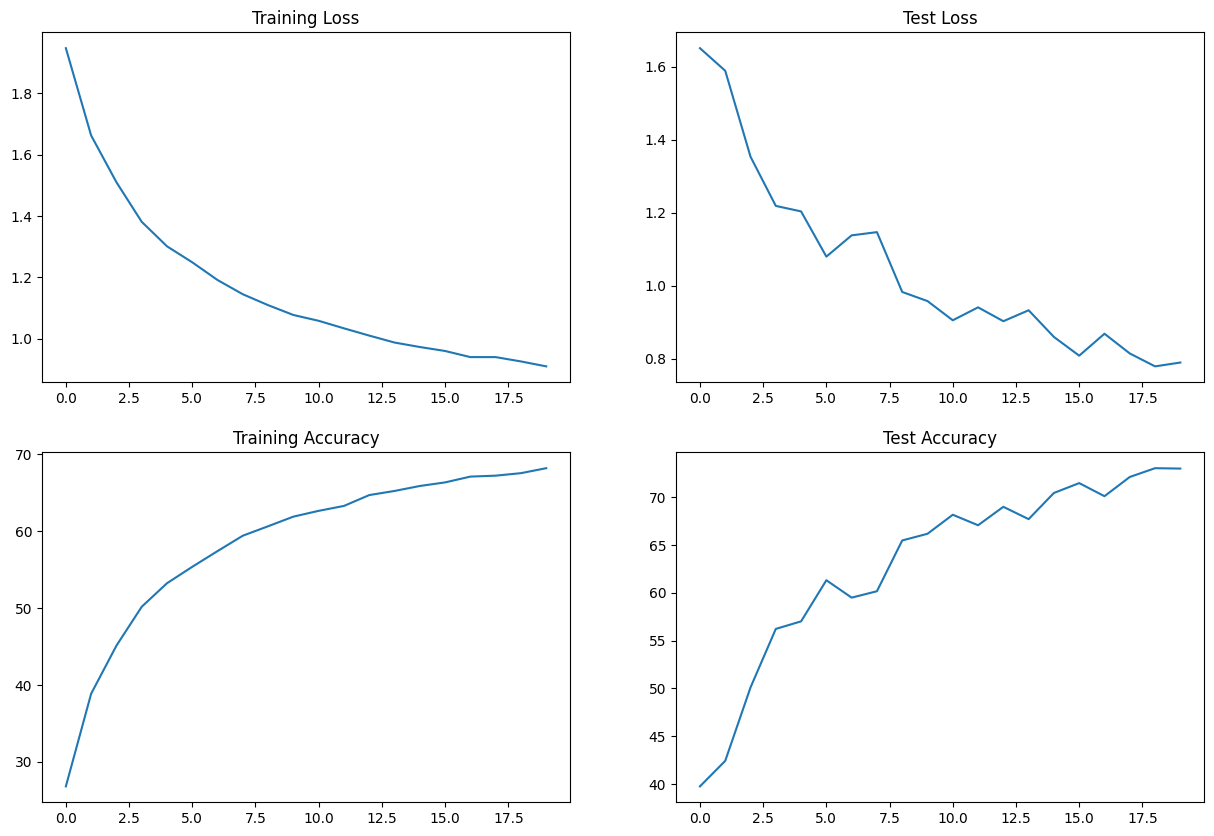

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")

In [16]:
reqData = 10

def GetIncorrectPreds(data, pPrediction, pLabels):
  images = []
  incorrectPreds = []
  nonMatchingLabels = []
  # print("pPrediction type:", type(pPrediction), "Shape:", pPrediction.shape)
  # print("pLabels type:", type(pLabels), "Shape:", pLabels.shape)
  preds = pPrediction.argmax(dim=1)
  indexes = pLabels.ne(pPrediction.argmax(dim=1))
  for image, pred, label in zip(data, preds, pLabels):
      if pred.ne(label):
          images.append(image.cpu())
          incorrectPreds.append(pred.cpu().item())
          nonMatchingLabels.append(label.cpu().item())

  # print("Incorrect Preds:", incorrectPreds, "Labels:", nonMatchingLabels)
  return images, incorrectPreds, nonMatchingLabels

def incorrectOutcomes(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0
    incorrectPreds = []
    nonMatchingLabels = []
    images = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            imageSet, incPred, nonMatchLabel = GetIncorrectPreds(data, output, target)
            nonMatchingLabels = nonMatchingLabels + nonMatchLabel
            incorrectPreds = incorrectPreds + incPred
            images = images + imageSet

            if len(incorrectPreds) > reqData:
              break

    return images, nonMatchingLabels, incorrectPreds

In [17]:
images, nonMatchingLabels, incorrectPreds = incorrectOutcomes(mymodel, device, test_loader)

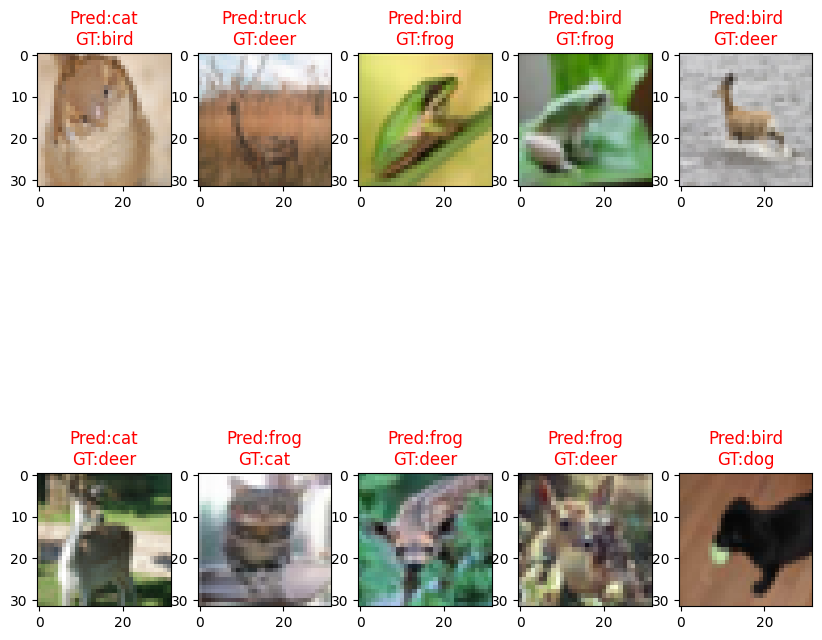

In [18]:
plt.figure(figsize=(10,10))
plt.tight_layout()

right = 0
mistake = 0

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

for i in range(reqData):
    image = images[i]
    pred = classes[incorrectPreds[i]]
    gt = classes[nonMatchingLabels[i]]

    plt.subplot(2,int(reqData/2),i+1)
    plt.imshow(imshow(image))
    plt.axis('on')

    # ret = model.predict(data, batch_size=1)
    #print(ret)

    plt.title("Pred:" + pred + "\nGT:" + gt, color='#ff0000', fontdict={'fontsize': 12})

plt.show()